<a href="https://colab.research.google.com/github/jeevisha3008/Recommender-System/blob/master/als_with_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install pyspark

     |████████████████████████████████| 204.7MB 78kB/s 
     |████████████████████████████████| 204kB 36.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=106d5dba607c581890b87a634611d98641ae80f01daad478b22ed15ba2e95dc1
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [5]:
import pandas as pd

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [6]:
# Create spark
spark = SparkSession.builder.getOrCreate()

In [8]:
from google.colab import files
uploaded = files.upload()

Saving ratings.csv to ratings.csv


In [9]:
import io
movie_ratings = pd.read_csv(io.BytesIO(uploaded['ratings.csv']))

In [10]:
ratings_movie_summary = movie_ratings.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
ratings_movie_summary.head(10)

,count,mean,std
movie_id,,,
1,452,3.878319,0.927897
2,131,3.206107,0.966497
3,90,3.033333,1.212760
4,209,3.550239,0.965069
5,86,3.302326,0.946446
6,26,3.576923,1.301478
7,392,3.798469,0.982037
8,219,3.995434,1.002281
9,299,3.896321,1.042368


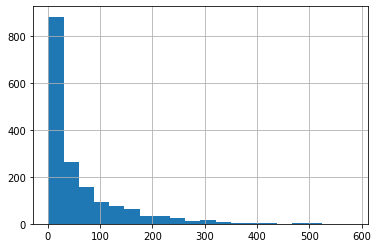

In [11]:
ratings_movie_summary.sort_values(by='count')['count'].hist(bins=20)

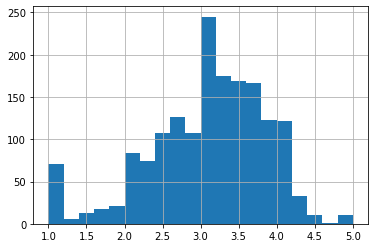

In [12]:
ratings_movie_summary.sort_values(by='mean')['mean'].hist(bins=20)

In [13]:
data = spark.read.option("header","true").option("inferSchema","true").format("csv")\
       .load("ratings.csv")

In [14]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- unix_timestamp: integer (nullable = true)



In [15]:
data=data.drop('_c0','unix_timestamp')

In [16]:
data.show()

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|    196|     242|     3|
|    186|     302|     3|
|     22|     377|     1|
|    244|      51|     2|
|    166|     346|     1|
|    298|     474|     4|
|    115|     265|     2|
|    253|     465|     5|
|    305|     451|     3|
|      6|      86|     3|
|     62|     257|     2|
|    286|    1014|     5|
|    200|     222|     5|
|    210|      40|     3|
|    224|      29|     3|
|    303|     785|     3|
|    122|     387|     5|
|    194|     274|     2|
|    291|    1042|     4|
|    234|    1184|     2|
+-------+--------+------+
only showing top 20 rows



In [17]:
ratings = data.repartition(8)

In [18]:
# Number of ratings in matrix
numerator = ratings.count()

In [19]:
# Distinct users and movies
users = ratings.select("user_id").distinct().count()
movies = ratings.select("movie_id").distinct().count()

# Number of ratings matrix could contain if no empty cells
denominator = users * movies

In [20]:
#Calculating sparsity
sparsity = 1 - (numerator*1.0 / denominator)
print ("Sparsity: "), sparsity

Sparsity: 


(None, 0.9369533063577546)

In [21]:
ratings.select("user_id").distinct().count()

943

In [22]:
ratings.rdd.getNumPartitions()

8

In [23]:
# Split data
(training_data, test_data) = ratings.randomSplit([0.8, 0.2])

In [24]:
# Build ALS model
from pyspark.ml.recommendation import ALS

als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", 
             nonnegative=True,
            coldStartStrategy="drop", implicitPrefs=False)

In [25]:
# Fit model to training data
model = als.fit(training_data)  

In [26]:
# Generate predictions on test_data
predictions = model.transform(test_data)

In [27]:
predictions.show()

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
|    580|     148|     4|  3.081432|
|    633|     148|     1| 3.2548249|
|    406|     148|     3| 2.7375798|
|     27|     148|     3|  3.330869|
|    330|     148|     4| 4.3888893|
|    372|     148|     5| 3.6680844|
|    618|     148|     3| 2.7420669|
|    923|     148|     4| 3.7634676|
|     54|     148|     3| 3.5638394|
|    620|     148|     3|  4.249805|
|    430|     148|     2| 2.7120147|
|    717|     148|     3| 3.6074827|
|    244|     148|     2| 2.7579458|
|     51|     148|     3|  3.192152|
|    821|     148|     3| 3.6074452|
|    403|     148|     5| 3.8249264|
|    361|     148|     1| 2.5993638|
|     90|     148|     2| 3.2635624|
|    749|     148|     3| 3.7247958|
|    506|     148|     3| 3.3372307|
+-------+--------+------+----------+
only showing top 20 rows



In [28]:
predictions.filter(predictions.user_id==11).orderBy('prediction', ascending=False).show()

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
|     11|     190|     3|    4.1814|
|     11|      98|     2| 4.1401134|
|     11|      12|     2|  4.029972|
|     11|     423|     5| 3.8769834|
|     11|     213|     4| 3.8477998|
|     11|     208|     4| 3.8026073|
|     11|     663|     4|  3.750984|
|     11|     435|     4| 3.6796203|
|     11|     173|     5| 3.6091387|
|     11|     402|     4| 3.5663774|
|     11|     425|     4|  3.473208|
|     11|     713|     5| 3.4627445|
|     11|     228|     3| 3.4525614|
|     11|      70|     4| 3.4149816|
|     11|     742|     3|  3.396487|
|     11|     733|     4| 3.3704045|
|     11|     730|     3| 3.3516939|
|     11|     723|     5|  3.306344|
|     11|     747|     3| 3.3035917|
|     11|     175|     3| 3.3009868|
+-------+--------+------+----------+
only showing top 20 rows



In [29]:
# Tell Spark how to evaluate predictions
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [30]:
# Obtain and print RMSE
rmse = evaluator.evaluate(predictions)
print ("RMSE: "), rmse

RMSE: 


(None, 0.9223619420920909)

In [76]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

In [82]:
#create a new ALS estimator
als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", coldStartStrategy="drop")
#define a grid for both parameters
#this will test 9 different combinations of the 2 parameters
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 15]) \
    .addGrid(als.maxIter, [10, 15, 20]) \
    .build()

In [83]:
# split the data with a ratio of 90% training, 10% validation
# define the estimator and evaluator to use to determine the best model
# also pass in the parameter grid to search over
trainValSplit = TrainValidationSplit(estimator = als, estimatorParamMaps=paramGrid, 
                                    evaluator = RegressionEvaluator(metricName="rmse", predictionCol="prediction", labelCol="rating"), 
                                     trainRatio = 0.9, parallelism = 4)

In [84]:
# fit the model to the training data
model = trainValSplit.fit(training_data)

In [80]:
# retrieve the best model
bestModel = model.bestModel

In [81]:
# transform test data using bestModel
predictions = bestModel.transform(test_data)
# evaluate the predictions
rmse = evaluator.evaluate(predictions)
print('The Root Mean Square Error is %.3f' % (rmse))

The Root Mean Square Error is 0.923


In [45]:
from google.colab import files
uploaded = files.upload()

Saving item.csv to item.csv


In [37]:
ALS_recommendations = model.recommendForAllUsers(5)

In [46]:
item_data = spark.read.option("header","true").option("inferSchema","true").format("csv")\
       .load("item.csv"

In [38]:
ALS_recommendations.registerTempTable("ALS_recs_temp")

In [41]:
clean_recs = spark.sql("""SELECT user_id,
                            movieIds_and_ratings.movie_id AS movie_id,
                            movieIds_and_ratings.rating AS prediction
                          FROM ALS_recs_temp
                          LATERAL VIEW explode(recommendations) exploded_table
                          AS movieIds_and_ratings""")

In [53]:
exploded_recs = spark.sql("""SELECT user_id,
explode(recommendations) AS MovieRec
FROM ALS_recs_temp""")
exploded_recs.filter(exploded_recs['user_id']==11).show()

+-------+-----------------+
|user_id|         MovieRec|
+-------+-----------------+
|     11|[1643, 5.2275543]|
|     11|  [1449, 4.56424]|
|     11|[1642, 4.4788976]|
|     11| [1398, 4.442783]|
|     11| [1064, 4.391003]|
+-------+-----------------+



In [43]:
# Adding Lateral View
ALS_recommendations.registerTempTable("ALS_recs_temp")
clean_recs = spark.sql("""SELECT user_id,
movieIds_and_ratings.movie_id AS movie_id,
movieIds_and_ratings.rating AS prediction
FROM ALS_recs_temp
LATERAL VIEW explode(recommendations) exploded_table
AS movieIds_and_ratings""")

In [44]:
ALS_recommendations.registerTempTable("ALS_recs_temp")
clean_recs = spark.sql("""SELECT user_id,
movieIds_and_ratings.movie_id AS movie_id,
movieIds_and_ratings.rating AS prediction
FROM ALS_recs_temp
LATERAL VIEW explode(recommendations) exploded_table
AS movieIds_and_ratings""")
clean_recs.show()

+-------+--------+----------+
|user_id|movie_id|prediction|
+-------+--------+----------+
|    471|    1033| 5.4304113|
|    471|    1233| 5.0112443|
|    471|     990| 4.9166436|
|    471|     323| 4.9083886|
|    471|    1025| 4.8722334|
|    463|    1643|  4.649138|
|    463|    1449|  4.510346|
|    463|    1137|  4.316956|
|    463|    1159| 4.3035936|
|    463|    1193|  4.299507|
|    833|    1643| 4.9987044|
|    833|     320| 4.4960856|
|    833|    1367|  4.311809|
|    833|    1368| 4.2807136|
|    833|    1005|  4.268629|
|    496|    1643| 4.6665845|
|    496|      75| 4.5537467|
|    496|    1019| 4.3608546|
|    496|     115| 4.3358183|
|    496|    1137| 4.3254666|
+-------+--------+----------+
only showing top 20 rows



In [65]:
clean_recs.join(item_data, ["movie_id"],"left").drop('_c0').show()

+--------+-------+----------+--------------------+------------+------------------+--------------------+-------+------+---------+---------+---------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+
|movie_id|user_id|prediction|         movie_title|release_date|video_release_date|            IMDb_URL|unknown|Action|Adventure|Animation|Childrens|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western|
+--------+-------+----------+--------------------+------------+------------------+--------------------+-------+------+---------+---------+---------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+
|    1033|    471| 5.4304113|Homeward Bound II...| 08-Mar-1996|              null|http://us.imdb.co...|      0|     0|        1|        0|        1|     0|    0|          0|    0|      0|        0|     0|      0|      0|      0| 

In [69]:
# Filtering Recommendations
a = clean_recs.join(ratings, ["user_id","movie_id"],"left")

+-------+--------+----------+------+
|user_id|movie_id|prediction|rating|
+-------+--------+----------+------+
|    833|     320| 4.4960856|     4|
|    804|      50| 4.6538973|     4|
|    322|     127|  4.701808|     4|
|    683|     127| 4.4324093|     4|
|    796|     313| 4.5541697|     4|
|    796|     272|  4.422848|     4|
|    723|     169| 3.8016565|     4|
|    667|     694|  4.634792|     4|
|    844|     318| 4.1871004|     4|
|     91|      64|  4.617357|     4|
|     91|     313|  4.566746|     4|
|    663|     318| 4.5141163|     4|
|    578|    1016|  3.685105|     4|
|    222|     313| 4.2568808|     4|
|    727|      50|  4.148682|     4|
|    727|     174|  4.117096|     4|
|    209|     408| 4.2265244|     4|
|    152|     313|  5.428705|     4|
|    618|      64| 4.0727735|     4|
|    631|     272| 4.0476813|     4|
+-------+--------+----------+------+
only showing top 20 rows



In [75]:
a.na.drop().show()

+-------+--------+----------+------+
|user_id|movie_id|prediction|rating|
+-------+--------+----------+------+
|    833|     320| 4.4960856|     4|
|    148|     169| 4.9279766|     5|
|    148|     408| 4.9040766|     5|
|    148|     114|  4.872669|     5|
|    392|     178| 4.8569446|     5|
|    623|      50|   4.47573|     5|
|     65|     318| 4.6309342|     5|
|    804|      50| 4.6538973|     4|
|    296|     963| 5.0330915|     5|
|    296|     483| 5.0024323|     5|
|    322|     127|  4.701808|     4|
|    321|     483|  4.210812|     5|
|    593|     272| 4.6507645|     5|
|    593|     318| 4.5332203|     5|
|    683|     127| 4.4324093|     4|
|    642|     313|  4.813728|     5|
|    796|    1269|  4.572686|     5|
|    796|     313| 4.5541697|     4|
|    796|     272|  4.422848|     4|
|    126|    1175| 5.0234947|     5|
+-------+--------+----------+------+
only showing top 20 rows

